## NIRSpec/G395H Reduction

This notebook will walk you through the basics of data analysis for NIRSpec/G395H BOTS observations.
Note that the process to follow will be the same for the other NIRSpec grisms -- we're using G395H here as an example since that was the grism used in the JWST Transiting Exoplanet Community Early Release Science (ERS) program. 

In [2]:
# First thing to do is set your CRDS variables so we can download the most up-to-date JWST 
# reference files. 

import os
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Now let's get some data! exoTEDRF has a useful functionality which allows you to automatically grab any (public) data from the MAST archive.  
Let's use the WASP-39b transit observations from the JWST Transiting Exoplanet Community Early Release Science program published in [Alderson et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.614..664A/abstract).

In [ ]:
from exotedrf.extra_functions import download_observations

# We want all data associated with proposal ID 1366 for target WASP-39b. Additionally we 
# specify NIRSPEC/SLIT since this program also observed the same planet with NIRISS and NIRCam. 
# Lastly, we want to specify G395H as the filter since this target was also observed with PRISM! 

download_observations(proposal_id='1366', objectname='WASP-39b', instrument_name='NIRSPEC/SLIT', 
                      filters='G395H')

# This will store all files in a folder in the present directory called DMS_uncal.

Now let's create output directories to store our data products.

In [3]:
from exotedrf import utils

# Generate output directories
utils.verify_path('pipeline_outputs_directory')
utils.verify_path('pipeline_outputs_directory/Stage1')
utils.verify_path('pipeline_outputs_directory/Stage2')
utils.verify_path('pipeline_outputs_directory/Stage3')
utils.verify_path('pipeline_outputs_directory/Stage4')

exoTEDRF is subdivided into four stages, mirroring the STScI jwst pipeline.  
The stages are as follows:
 - Stage 1: Detector Level Processing 
 - Stage 2: Spectroscopic Processing
 - Stage 3: 1D Spectral Extraction
 - Stage 4: Light Curve Fitting 
 
This notebook will walk you through stages 1 to 3, or from raw data to extracted stellar spectra, mostly following the steps laid out in [Ahrer et al. (2024)](). 

### Stage 1 -- Detector-Level Processing

Stage 1 performs multiple important calibrations on the raw, 4D (integrations, groups, y-pixel, x-pixel) data cubes. Several steps are simply wrappers around the existing functionalities of the STScI pipeline, whose documentation can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html).

In [4]:
from exotedrf import stage1

# First define some input and output directory paths.

uncal_indir = 'DMS_uncal/'  # Where our uncalibrated files are found. 
outdir_s1 = 'pipeline_outputs_directory/Stage1/'  # Where to save our Stage 1 output files.

Now let's make a list with all the uncal input files. With NIRSpec/G395H, the spectrum is dispersed across two seperate detectors, called NRS1 and NRS2. Each detector has slightly different properties and we will therefore process each of them seperately.  
In this case, the full TSO is broken up into three segments for each detector.

In [5]:
filenames_1 = [uncal_indir+'jw01366003001_04101_00001-seg001_nrs1_uncal.fits', 
               uncal_indir+'jw01366003001_04101_00001-seg002_nrs1_uncal.fits',
               uncal_indir+'jw01366003001_04101_00001-seg003_nrs1_uncal.fits']

filenames_2 = [uncal_indir+'jw01366003001_04101_00001-seg001_nrs2_uncal.fits', 
               uncal_indir+'jw01366003001_04101_00001-seg002_nrs2_uncal.fits',
               uncal_indir+'jw01366003001_04101_00001-seg003_nrs2_uncal.fits']

Let's check the readout pattern of the observations. 

In [6]:
from astropy.io import fits

with fits.open(filenames_1[0]) as file:
    print('No. integrations: {}'.format(file[0].header['NINTS']))
    print('No. groups: {}'.format(file[0].header['NGROUPS']))
    print('subarray: {}'.format(file[0].header['SUBARRAY']))

No. integrations: 465
No. groups: 70
subarray: SUB2048


Here we can see that the full TSO consists of 465 integrations, with 70 groups per integration using the 32x2048 pixel subarray. 

Let's now take a look at what the raw data looks like.

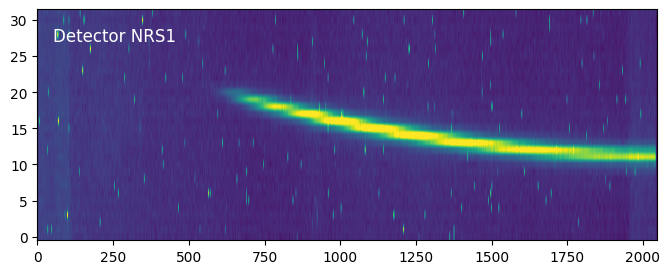

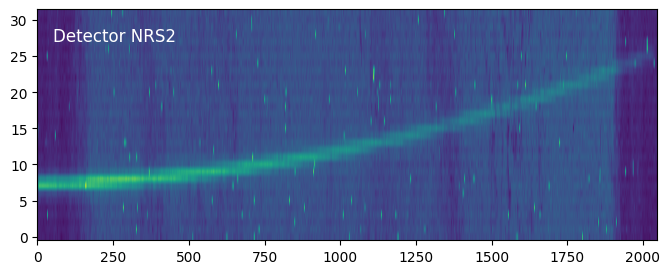

In [7]:
import matplotlib.pyplot as plt

# For NRS1
with fits.open(filenames_1[0]) as file:
    plt.figure(figsize=(8, 3))
    # Let's check out the last group of the 10th integration
    plt.imshow(file[1].data[10, -1], aspect='auto', origin='lower', vmax=3e4)
    plt.text(50, 27, 'Detector NRS1', c='white', fontsize=12)
    plt.show()

# For NRS2
with fits.open(filenames_2[0]) as file:
    plt.figure(figsize=(8, 3))
    # Let's check out the last group of the 10th integration
    plt.imshow(file[1].data[10, -1], aspect='auto', origin='lower', vmax=3e4)
    plt.text(50, 27, 'Detector NRS2', c='white', fontsize=12)
    plt.show()

Here we can clearly see the target spectral traces in both detectors as well as a number of detector effects that we need to take care of.

We're now ready to start with the actual reduction.

#### DQ Initalization Step
Intializes the data quality flags.  

As mentioned above, NIRSpec/G395H spectra are spread across two detectors, each of which needs to be processed seperately. However, the steps to reduce data from either detector are the same! Any small tweaks required for NRS2 vs NRS1 are automatically handled by exoTEDRF under the hood. Therefore, in order to not repeat every step twice in this tutorial, we're only going to walk through NRS1 here.

In [ ]:
# Initialize the step by passing the input files and the directory to which we want to save 
# the outputs. 
# There's also an option to pass an existing deepstack of this TSO in order to identify and flag 
# hot pixels which may not be in the default DQ maps. 

step = stage1.DQInitStep(filenames_1, deepframe=None, output_dir=outdir_s1)

# Now run the step! 

results = step.run(save_results=True, force_redo=True)

#### Saturation Detection Step
Flags any saturated pixels in the observations.  

In [ ]:
# This time we pass the outputs from the previous step as the inputs for this step.

step = stage1.SaturationStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

#### Superbias Subtraction Step
Now we subtract the superbias level from all frames.  

In [ ]:
step = stage1.SuperBiasStep(results, output_dir=outdir_s1)

# This step has options for diagnostic plotting. Specifying do_plot=True will create the step 
# plot and save it to the output directory.

results = step.run(save_results=True, force_redo=True, do_plot=True)

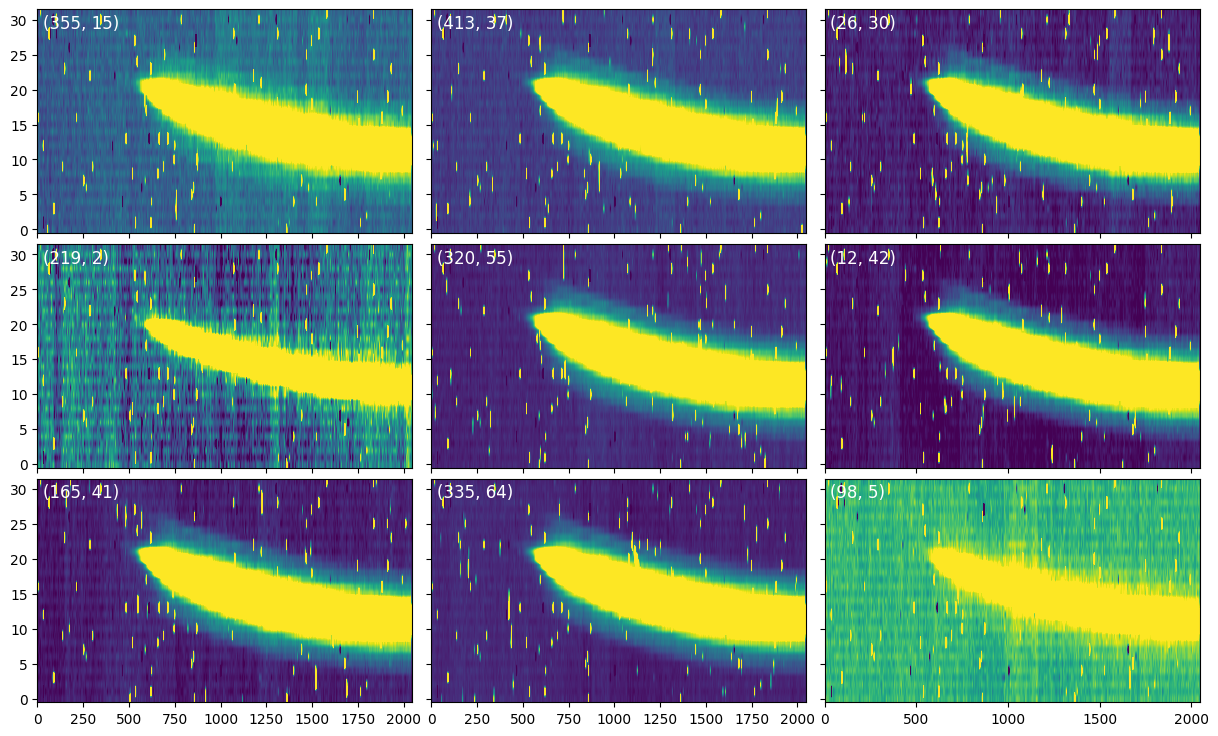

In [8]:
# Display the step plot.

from IPython.display import Image

Image(filename=outdir_s1 + 'superbiasstep_nrs1.png') 

Nine random frames are shown in the diagnostic plot, where we can verify that many of the detector effects we saw above are now gone.

#### Dark Current Subtraction Step
Another wrapper around an STScI pipeline step. This one is optional, and many analyses skip it as the existing dark current reference files show clear residual 1/f noise. Moreover, particularly for NIR observations, the actual dark current signal is extremely small. However, I include it here for completeness!

In [ ]:
step = stage1.DarkCurrentStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

#### 1/f Noise Correction Step
1/f noise is time-correlated noise which manifests in NIRSpec observations as column-correlated "stripes". The 1/f noise is actually caused by time-varying voltage levels as the detector is read, and as such it is actually one of the very last noise sources (along with read noise) to be injected into the data. exoTEDRF, therefore, corrects 1/f noise at the group-level (i.e., before ramp fitting).  

Unlike with NIRISS/SOSS, the 1/f correction also double as the background subtraction for NIRSpec/G395H! There are sufficient amounts of non-illuminated pixels in each column to use to estimate both the time-correlated 1/f noise, as well as the faint zodi background signal.

Another thing to note is that although we're performing this correction now, at the group level, we're going to repeat it again after ramp fitting. This is just to make extra sure that we've removed all the background light and 1/f noise that we can.

For NIRSpec, exoTEDRF provides two different 1/f correction methods. Here, we're going to use the simplest one, "median", which simply consists of constructing a median stack for the observation, and subtracting a median of all unilluminated pixels in each column.

It's a good idea to disclude any bad pixels from the calculation so that we don't bias the 1/f value calculated for a given column. To address this, there is an optional ```pixel_masks``` keyword to which can be passed masks of pixels to exclude in each frame.   
If no such masks are available, the step will automatically mask all pixels with non-zero DQ flags, as well as obvious outliers.  

exoTEDRF produces pixel masks for this specific purpose during the RampFitStep in Stage 1, so it is always a good idea to do a first quick run through of the pipeline to get a feel for the data, and create these useful auxiliary files. Then do a second "good" reduction using the outputs from the first pass.

In [ ]:
pixel_masks = None

# If available, the exoTEDRF pixel masks will have the filenames XXX_pixelflags.fits and there
# will always be one for each segment.

In [ ]:
# Initialize the step passing the input files as well as any auxiliary files mentioned above.
# Moreover, we also want to indicate the indices of the baseline integrations and the 1/f 
# correction method that we wish to use. 

step = stage1.OneOverFStep(results, baseline_ints=[50, -50], output_dir=outdir_s1, 
                           pixel_masks=pixel_masks, method='median')

# even_odd_rows=True calculates seperate 1/f noise values for even- and odd-values rows.
# nirspec_mask_width=16 defines the width of pixels around the target spectral trace to mask. 
# It's a good idea to make this at least as large as your planned extraction aperture. 

results = step.run(save_results=True, even_odd_rows=True, force_redo=True, do_plot=True, 
                   nirspec_mask_width=16)

Two diagnostic plots are produced here. The first will be our familiar nine-panel plot, now showing difference images after the 1/f noise correction. We don't want to see any column-correlated noise left here!

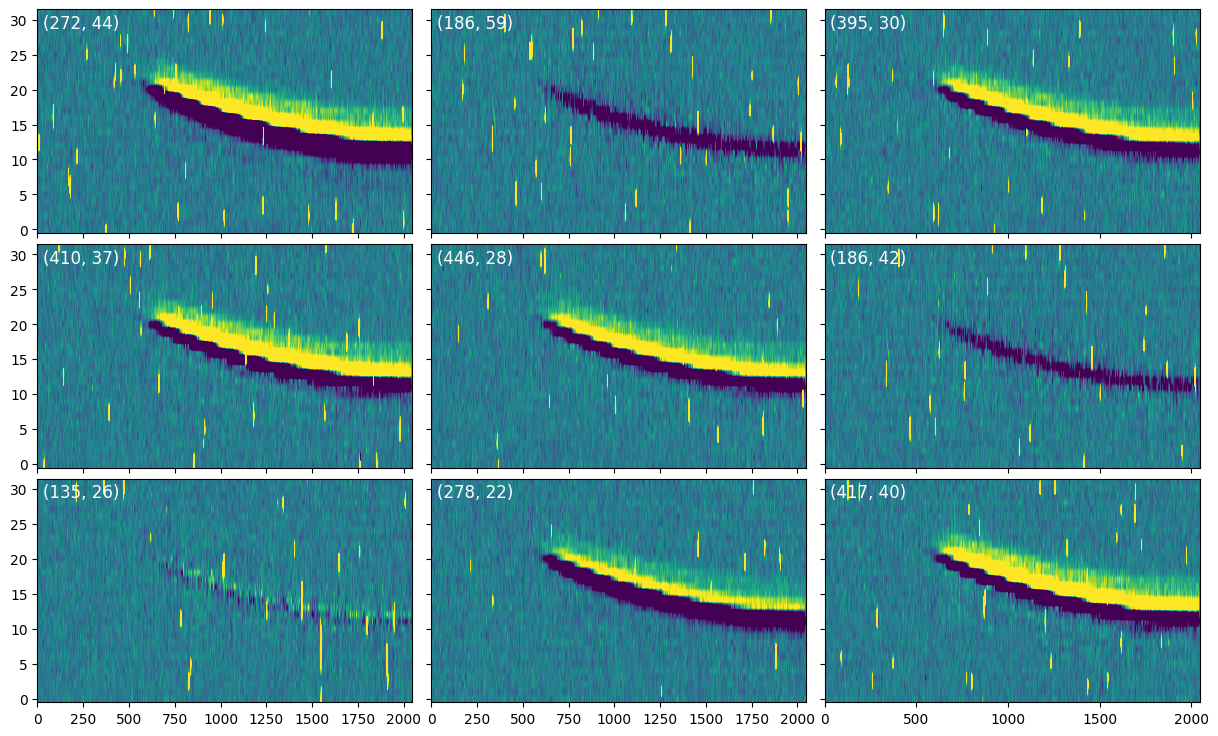

In [9]:
Image(filename=outdir_s1 + 'oneoverfstep_1_nrs1.png') 

The second is a power series of the data before and after the 1/f correction. The power spectral density before the correction clearly increases, roughly linearly, towards shorter frequencies (hence 1/f!). After the correction though, we can see that the psd is much flatter. We have done a pretty good job of removing all the 1/f noise!

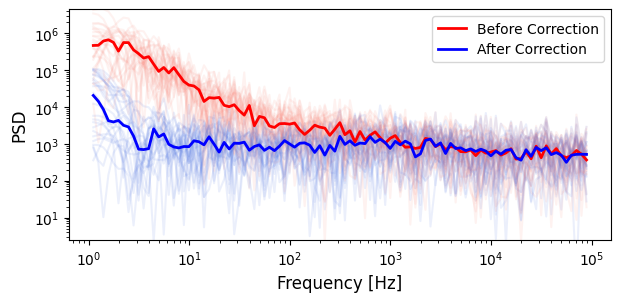

In [10]:
Image(filename=outdir_s1 + 'oneoverfstep_2_nrs1.png') 

#### Linearity Step
The HgCdTe detectors used in NIRSpec are not perfectly linear, which means that as saturation is approached, the counts begin to plateau and less flux is recorded than is actually observed. This is not an issue just with NIRSpec, but all other JWST instruments as well. This step applies pre-calcuated polynomials to correct these non-linearity effects in the ramp. 

In [ ]:
step = stage1.LinearityStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True, do_plot=True)

The first diagnostic plot shows (mean-subtracted) group-to-group differences. For a perfect non-linearity correction, we would expect each difference to be identical. The correction is therefore not perfect, but it's at least a little better than when we started!

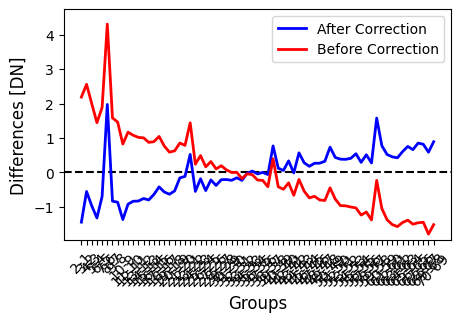

In [11]:
Image(filename=outdir_s1 + 'linearitystep_1_nrs1.png') 

#### Jump Detection Step
We now want to detect and flag cosmic ray hits in the data. There are two main ways to do this: up-the-ramp or time-domain flagging. 

The up-the-ramp flagging algorithm is the default algorithm in the STScI pipeline. In entails identifying discontinuities above a certain threshold in ramps, and flagging these as jumps. Unfortunately, this method can be quite temperamental and has been found by many studies to flag random noise. It also cannot be applied to ngroup=2 datasets.

The time-domain flagging method uses a sigma clipping algorithm to identify cosmic ray hits in the time domain. This method also has the benefit of working for observations with any number of groups. 

In [ ]:
step = stage1.JumpStep(results, output_dir=outdir_s1)

# Here we will use the time-domain rejection by specifying flag_in_time=True, and use a clipping 
# threshold of 7 sigma.
# In order to use the up-the-ramp flagging, specify instead flag_up_ramp=True and pass an 
# appropriate value to the rejection_threshold keyword. 

results = step.run(save_results=True, force_redo=True, flag_in_time=True, 
                   time_rejection_threshold=7, do_plot=True)

The diagnostic plot here shows the locations of flagged jumps, as well as hot pixels in nine frames. 

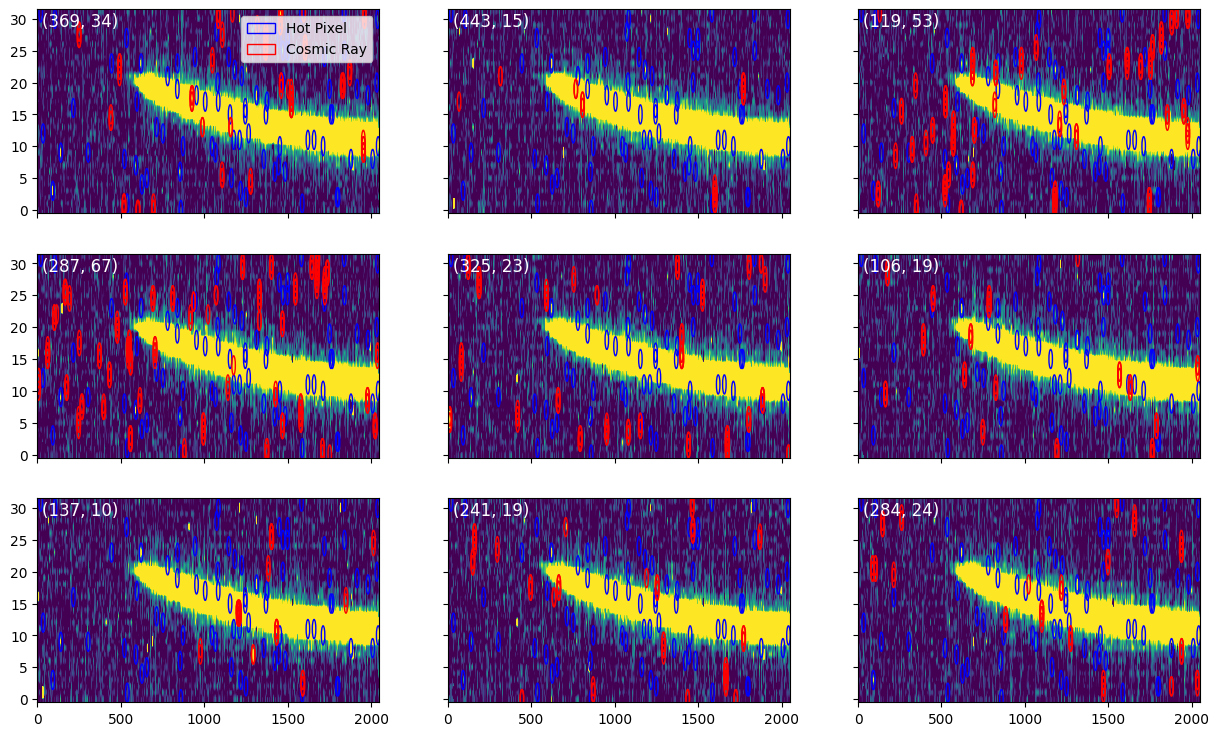

In [12]:
Image(filename=outdir_s1 + 'jump_nrs1.png') 

#### Ramp Fit Step
Now that all the initial detector-level calibrations are done, we are ready for ramp fitting! This step is a wrapper around the STScI pipeline step that fits a slope and intercept as a function of group to each pixel. We don't use the intercept values, and only care about the slopes moving forwards.

This step also produces outlier pixel masks by combining all existing data flags. One flag file is produced for each segment and is saved in the Stage 1 directory with the name XXX_pixelflags.fits.

In [ ]:
step = stage1.RampFitStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

#### Gain Scale Step
The gain scale correction does the conversion from DN/s to e-/s by multiplying the data values by the wavelength dependent NIRSpec gain (1.6 e-/DN on average).  

In [ ]:
step = stage1.GainScaleStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

We are now ready to start with Stage 2!

### Stage 2 -- Spectroscopic Processing

This stage performs some additional calibrations on the, now 3D (integrations, y-pixel, x-pixel), data after the ramp fitting to make the data ready for the spectral extraction. Once again, information on the default STScI pipeline steps can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html).

In [13]:
from exotedrf import stage2

# Let's now save outputs to the Stage 2 subdirectory. 

outdir_s2 = 'pipeline_outputs_directory/Stage2/'

For those of you who have worked through the NIRISS/SOSS tutorial, most of what we've done so far will be wuite familiar. However, now we will start to diverge more from that tutorial. This is because unlike NIRISS/SOSS, NIRSpec is a slit spectrograph. Therefore the exact wavelength solution will depend on the positioning of the source within the slit. The next four steps are all mostly wrappers around STScI pipeline steps, with some minor modifications, to derive the wavelength solution of the particular TSO being analyzed. 

#### Assign WCS Step
This is mostly a wrapper around the STScI pipeline step which assigns the appropriate WCS to the data. 

In [ ]:
step = stage2.AssignWCSStep(results, output_dir=outdir_s2)

results = step.run(save_results=True, force_redo=True)

#### 2D Extraction Step
Here, we use the previously defined WCS in order to create the intial wavelength solution for both detectors. We will then refine this wavelength solution later.

In [ ]:
step = stage2.Extract2DStep(results, output_dir=outdir_s2)

results = step.run(save_results=True, force_redo=True)

#### Source Type Determination Step
For multiple subsequent steps to function, we need to correctly identify the source type in our observations. For all exoplanet TSOs, the correct type is a point source.

In [ ]:
step = stage2.SourceTypeStep(results, output_dir=outdir_s2)

results = step.run(save_results=True, force_redo=True)

#### Wavelength Correction Step
Now that we have defined the precise WCS and know the source type and location within the slit, this step corrects the wavelengths solution in cases where the target is not centered perfectly within the slit.

In [ ]:
step = stage2.WaveCorrStep(results, output_dir=outdir_s2)

results = step.run(save_results=True, force_redo=True)

#### Integration-Level 1/f Correction Step
As mentioned previously, we will now repeat the 1/f and background correction that we did at the group level in order to remove any residual noise that may have managed to slip through.

Additionally, we can now make direct use of the bad pixel masks that we generated during ramp fitting.

In [ ]:
# Create list of paths to pixel mask files making sure that there is one for each segment.
pixel_masks = [outdir_s1 + 'jw01366003001_04101_00001-seg001_nrs1_pixelflags.fits',
               outdir_s1 + 'jw01366003001_04101_00001-seg002_nrs1_pixelflags.fits',
               outdir_s1 + 'jw01366003001_04101_00001-seg003_nrs1_pixelflags.fits']

For all other parameters we will use the same inputs as for the group-level correction.

In [ ]:
step = stage1.OneOverFStep(results, baseline_ints=[50, -50], output_dir=outdir_s2, 
                           pixel_masks=pixel_masks, method='median')

results = step.run(save_results=True, even_odd_rows=True, force_redo=True, do_plot=True, 
                   nirspec_mask_width=16)

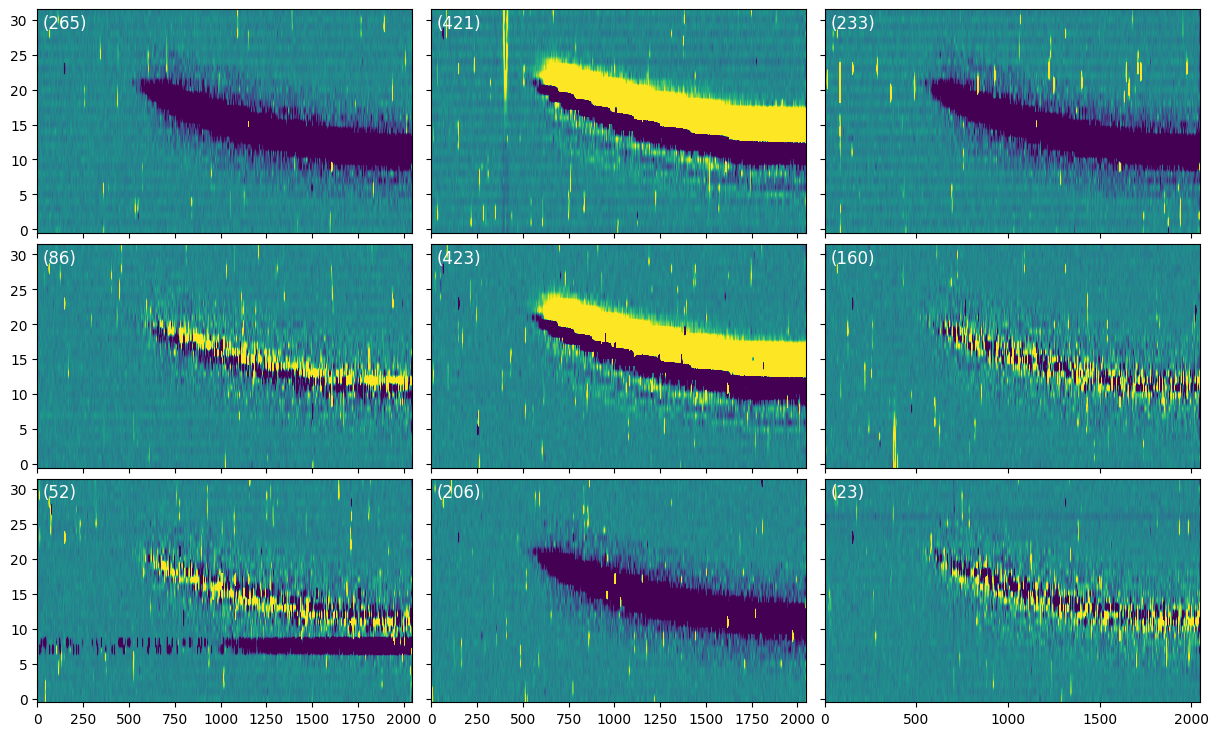

In [14]:
Image(filename=outdir_s2 + 'oneoverfstep_1_nrs1.png') 

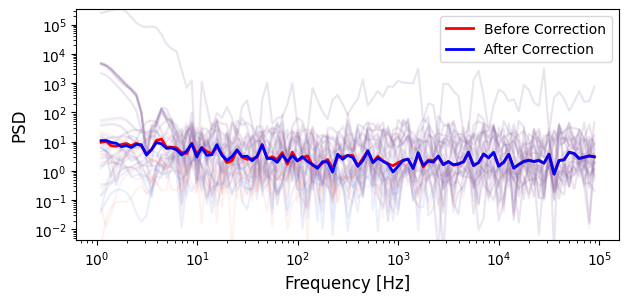

In [15]:
Image(filename=outdir_s2 + 'oneoverfstep_2_nrs1.png') 

Inspecting the two plots we can see that not much has changed. Particularly the fact that the power spectrum was already flat even before this second correction shows that we already did an excellent job removing the 1/f noise at the group level. But it's always good to make sure just in case!

#### Bad Pixel Correction Step
The penultimate step in Stage 2 is the final step which actually performs any data calibration. We are now going to interpolate any remaining bad pixels in the data to be ready for the spectral extraction.  

The BadPixStep performs two iterations of bad pixel detection and correction: the first is a spatial correction, and the second a temporal one. 

The spatial correction uses a median stack of all integrations to identify any pixels which are systematic outliers across the entire time series. These pixels are flagged, and then interpolate using a median of the surrounding pixels in each integration. Any pixels with DQ flags are also interpolated in this way.  

The temporal flagging works the same way as the time-domain jump detection, by flagging any pixels which are outliers along the time axis, and replacing them with a median of the surrounding pixels in time. 

In [ ]:
step = stage2.BadPixStep(results, baseline_ints=[50, -50], output_dir=outdir_s2)

# We're going to use a 10 sigma threshold for both the spatial and temporal corrections.

results, deepframe = step.run(save_results=True, force_redo=True, do_plot=True, 
                              space_thresh=10, time_thresh=10)

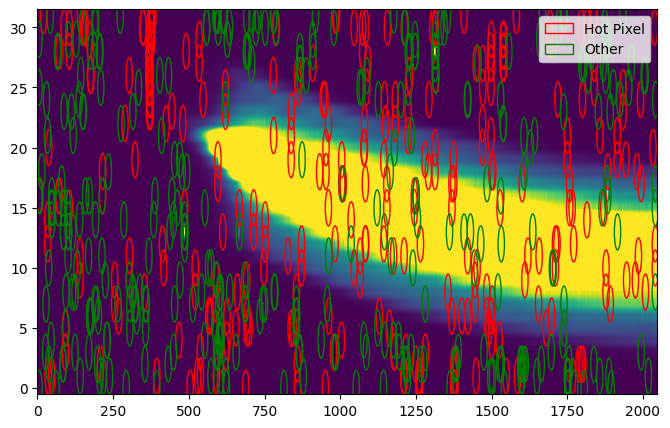

In [16]:
Image(filename=outdir_s2 + 'badpixstep_nrs1.png') 

The diagnostic plot here shows the deep stack (median stack) with the locations of all hot and other flagged pixels. 

#### Tracing Step
This step does not do any actual data calibration, but produces a number of auxiliarly files which may be useful either for improving the reduction, or in the subsequent light curve analysis. 

For NIRSpec observations, it has two major functionalities:  
1. Locate the centroids of the NIRSpec spectral trace via the [edgetrigger algorithm](https://ui.adsabs.harvard.edu/abs/2022PASP..134j4502R/abstract).  
2. (optional) Calculate the stability of the NIRSpec trace over the course of the TSO.  

The positions of the target traces are necessary for the spectral extraction, and this is the only functionality that happens by default.

The second, optional, functionality uses a principal component analysis to assess the stability of the NIRSpec spectral trace over the course of the TSO (see [Coulombe et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.620..292C/abstract) for more details). These eigenvalues may be incredibly useful for light curve detrending. 

In [ ]:
# Pass calculate_stability=True to do the principal component analysis.
step = stage2.TracingStep(results, deepframe=deepframe, output_dir=outdir_s2, 
                          calculate_stability=True)
 
step_results = step.run(save_results=True, force_redo=True, do_plot=True)
centroids = step_results[0]

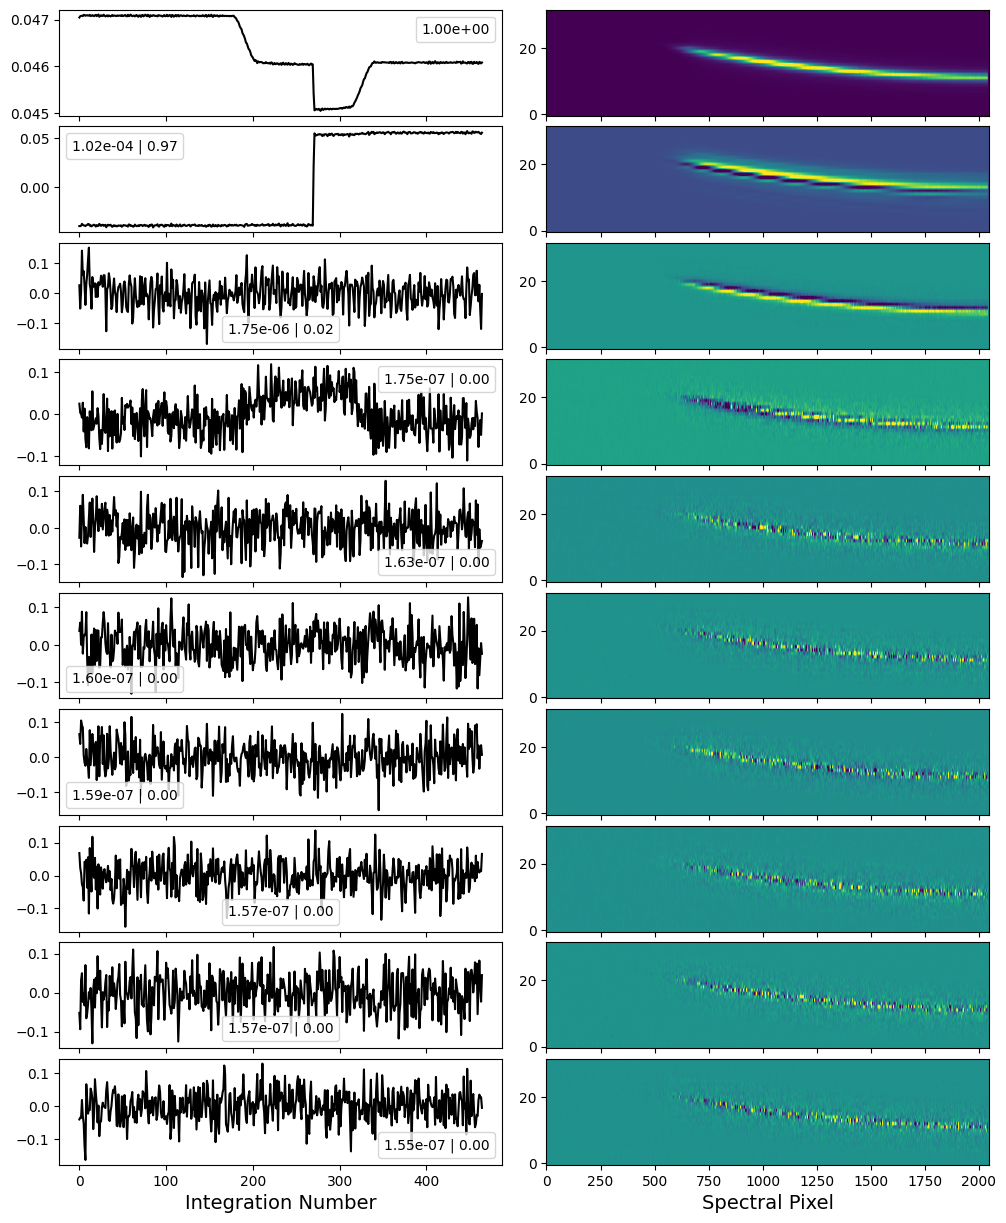

In [17]:
Image(filename=outdir_s2 + 'stability_pca_nrs1.png') 

The diagnostic plot here shows the first 10 PCs derived from this dataset. In general, only the first handful have any useful information. The first PC is almost always the transit (or eclipse) light curve. You'll notice that both the first and second PCs have a sharp break at integration ~275. This is a so-called tilt-event -- an abrupt change the PSF morphology caused by the thermal relaxation of one of the JWST primary mirror segments. The PCA is great at picking these up, even if they are not strong enough to be clearly visible in the light curves.

The PCA will also pick up any drifts in the position of the trace (3rd component here) or rotations, if present, all of which can be very useful for light curve detrending. 

Now one more thing before moving on to the extraction. Let's take a look at the deep stack and double check our trace positions.

In [18]:
# Read in the trace positions.

import pandas as pd

centroids = pd.read_csv(outdir_s2 + 'jw01366003001_04101_00001_nrs1_centroids.csv', comment='#')

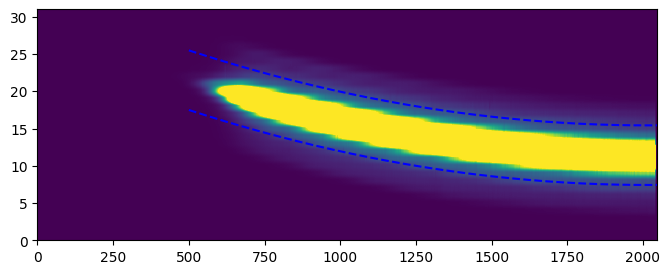

In [19]:
# Display the deepframe and the trace positions.

plt.figure(figsize=(8, 3))
plt.imshow(deepframe, aspect='auto', origin='lower', vmin=0, vmax=50)

# Show a width of 30 pixels around the trace.
plt.plot(centroids['xpos'], centroids['ypos']+4, ls='--', c='blue')
plt.plot(centroids['xpos'], centroids['ypos']-4, ls='--', c='blue')

plt.ylim(0, 31)
plt.show()

Everything looks good! We're now ready for Stage 3 and the spectral extraction.

### Stage 3 -- 1D Spectral Extraction

This is the shortest stage, as it just performs the 1D spectral extraction. 

In [20]:
from exotedrf import stage3

# Let's now save outputs to the Stage 3 subdirectory. 

outdir_s3 = 'pipeline_outputs_directory/Stage3/'

For NIRSpec observations, exoTEDRF performs a simple aperture extraction.

In [ ]:
step = stage3.Extract1DStep(results, extract_method='box', output_dir=outdir_s3)

# Here, we're using an aperture width of 8 pixels. 
# We also pass the trace positions from above.

results = step.run(extract_width=8, centroids=centroids, save_results=True, force_redo=True)

*Tada!* You now have stellar spectra of WASP-39! Let's take a quick look at the wavelength-dependent light curves.

For completeness, we're also going to look at NRS2 at the same time. The NRS2 spectra aren't directly produced by this notebook since we only ran NRS1. But remember that you can just repeat the same steps as above for NRS2.

In [22]:
# Open the extracted spectrum file and get the relevant quantities.

with fits.open(outdir_s3 + 'WASP-39_nrs1_box_spectra_fullres.fits') as spec:
    
    wave_nrs1 = np.mean([spec[1].data[0], spec[2].data[0]], axis=0)  # NRS 1 wavelengths    
    spec_nrs1 = spec[3].data  # NRS 1 spectra

# Do the same for NRS2

with fits.open(outdir_s3 + 'WASP-39_nrs2_box_spectra_fullres.fits') as spec:
    
    wave_nrs2 = np.mean([spec[1].data[0], spec[2].data[0]], axis=0)  # NRS 2 wavelengths
    spec_nrs2 = spec[3].data  # NRS 2 spectra
    
base = np.arange(150).astype(int)  # Baseline integrations
    
# Normalize the extracted spectra.  

spec_nrs1_norm = spec_nrs1 / np.nanmedian(spec_nrs1[base], axis=0)
spec_nrs2_norm = spec_nrs2 / np.nanmedian(spec_nrs2[base], axis=0)

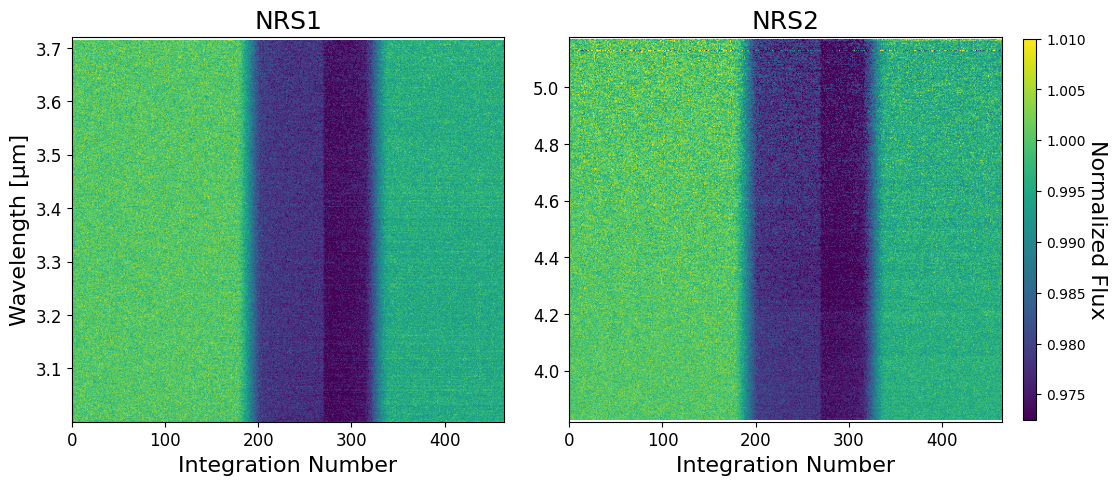

In [23]:
from exotedrf.plotting import make_2d_lightcurve_plot

# For NRS1, only the wavelengths >3µm are useable.

ii = np.where(wave_nrs1 >= 3)[0]

# Display the light curves.

kwargs = {'vmin': 0.9725, 'vmax': 1.01}
make_2d_lightcurve_plot(wave_nrs1[ii], spec_nrs1_norm[:, ii], wave_nrs2, spec_nrs2_norm, 
                        instrument='NIRSPEC', **kwargs)

Look at how clean those are!  

You're probably wondering why the second half of the transit is so much deeper than the first. That's the tilt event that we saw in the PCA earlier! Luckily, it can be easily modelled out using a simple step function.

exoTEDRF Stages 1 to 3 can also be run in script form via the provided run_DMS.py file. Simply fill out the corresponding yaml file with all relevant inputs, and you're good to go! Generally, I like to take a first pass at the data in a notebook, where I can double check the outputs of each step, and perhaps dig a bit deeper into some interesting things that pop up. I'll then use the script for the second pass.

You're now ready to fit some light curves and get your atmosphere spectrum, which is what you really want in the end, isn't it?!